# Dimensionality Reduction using an Autoencoder
Welcome to this project. We will introduce the theory behind an autoencoder (AE), its uses, and its advantages over PCA, a common dimensionality reduction technique.

## Some Prerequisites
- Basic-to-intermediate level understanding of Python
- Basic theory of neural networks is beneficial, but not required

## Project Outline
[**Task 1**](#task1): Package Importing and Introduction to Project

[**Task 2**](#task2): Dataset Creation and Preprocessing

[**Task 3**](#task3): Create a Baseline Model with PCA

[**Task 4**](#task4): Autoencoder Introduction and Training

[**Task 5**](#task5): Reducing Dimensionality with AE

<a id='task1'></a>
## Task 1: Importing and Introduction

In [ ]:
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [48]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, silhouette_score

In [49]:
colors = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

<a id='task2'></a>
## Task 2: Dataset Creation and Preprocessing

In [50]:
X, y = make_blobs(n_samples    = 20000,
                  n_features   = 50,
                  centers      = 20,
                  cluster_std  = 0.2,
                  center_box   = (-1.0, 1.0),
                  random_state = 17)

In [51]:
display(X.shape)
display(y.shape)

(20000, 50)

(20000,)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 17)

In [53]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

<a id='task3'></a>
## Task 3: Baseline Model

In [ ]:
pca = PCA(n_components = 2)

pca.fit(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    X_data = X_test_pca[y_test==label]
    
    plt.scatter(X_data[:,0], X_data[:,1], alpha=0.3, c=colors[index])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA Results')
plt.show()

<a id='task4'></a>
## Task 4: Autoencoder Theory and Training
![title](https://github.com/kevinpulido89/ML/blob/master/Images/ae_viz.pdf?raw=1)

https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
autoencoder = MLPRegressor(hidden_layer_sizes=(50,100,75,50,2,50,75,100,50),
                           alpha=1e-15,
                           batch_size=batch_size,
                           max_iter=25000,
                           random_state=None)

autoencoder.fit(X_train, X_train)

<a id='task5'></a>
## Task 5: Reducing Dimensionality with Encoder

In [ ]:
W = autoencoder.coefs_
biases = autoencoder.intercepts_

In [ ]:
for w in W:
    print(w.shape)

In [ ]:
encoder_weights = W[0:5]
encoder_biases = biases[0:5]

In [ ]:
def encode(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w,b) in enumerate(zip(encoder_weights, encoder_biases)):
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b
        else:
            res_ae = np.maximum(0, res_ae@w+b)
            
    return res_ae

In [ ]:
res_AE = encode(encoder_weights, encoder_biases, X_test) # (2000, 2)

In [ ]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    latent_space = res_AE[y_test==label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=colors[index])
    
plt.xlabel("Latent X")
plt.ylabel("Latent Y")
plt.title('AutoEncoder Results')
plt.show()

In [ ]:
silhouette_score(X_test, y_test)

In [ ]:
silhouette_score(X_test_pca, y_test)

In [ ]:
silhouette_score(res_AE, y_test)

# BASIC AUTOENCODER

## Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, ReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

- https://blog.keras.io/building-autoencoders-in-keras.html
- https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/
- https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

### Encoder

In [70]:
# this is the size of our encoded representations
encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_size = 50

# this is our input placeholder 50,100,75,50,2
input_img = Input(shape=(input_size,))
# x = Dropout(0.20)(input_img)
# x = LeakyReLU(alpha=0.1)(x)
# x = BatchNormalization()(input_img)

x = Dense(100, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5), name='E_He_normal')(input_img)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.01)(x)
x = BatchNormalization()(x)

x = Dense(75, kernel_initializer='glorot_uniform', activity_regularizer=regularizers.l1(10e-5), name='E_glorot_uniform')(x)
# x = Dropout(0.20)(x)
x = ReLU()(x)
x = BatchNormalization()(x)

x = Dense(50, activation='selu', kernel_initializer='lecun_normal', activity_regularizer=regularizers.l1(10e-5), name='E_lecun_normal')(x)
# x = Dropout(0.20)(x)
# x = Selu(alpha=0.1)(x)
x = BatchNormalization()(x)

encoded = Dense(encoding_dim, activation='relu', name='EncoderLayerOut_glorot_uniform')(x)

# this model maps an input to its encoded representation 
encoder = Model(input_img, encoded, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
E_He_normal (Dense)          (None, 100)               5100      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 100)               400       
_________________________________________________________________
E_glorot_uniform (Dense)     (None, 75)                7575      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 75)                0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 75)                300 

### Decoder

In [71]:
# create a placeholder for an encoded (32-dimensional) 2,50,75,100,50
latent_space = Input(shape=(encoding_dim,), name='DecoderLayerInput')

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5), name='D_He_normal')(latent_space)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(75, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(100, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

decoded_output = Dense(input_size, activation='sigmoid', name='DecoderLayerOut_glorot_uniform', )(x)

# create the decoder model
decoder = Model(latent_space, decoded_output, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DecoderLayerInput (InputLaye [(None, 2)]               0         
_________________________________________________________________
D_He_normal (Dense)          (None, 50)                150       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 50)                200       
_________________________________________________________________
dense_27 (Dense)             (None, 75)                3825      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 75)                0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 75)                300 

### Autoencoder

In [72]:
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
Encoder (Model)              (None, 2)                 17477     
_________________________________________________________________
Decoder (Model)              (None, 50)                20275     
Total params: 37,752
Trainable params: 36,752
Non-trainable params: 1,000
_________________________________________________________________


In [73]:
autoencoder.compile(optimizer='adam', # Or adadelta
                    loss='binary_crossentropy') #binary_crossentropy/mse

### Train AutoEncoder

Now let's train our autoencoder to reconstruct MNIST digits. First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [74]:
print(X_train.shape)
print(X_test.shape)

(18000, 50)
(2000, 50)


In [75]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%m%d_%H%M%S")+'_NN')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

epochs = 5
batch_size=32

History = autoencoder.fit(X_train, X_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=[eStop, tensorboard_callback])

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 8s 456us/sample - loss: 0.7113 - val_loss: 0.7224
Epoch 2/5
18000/18000 [==============================] - 5s 302us/sample - loss: 0.6947 - val_loss: 0.7409
Epoch 3/5
18000/18000 [==============================] - 6s 310us/sample - loss: 0.6895 - val_loss: 0.7115
Epoch 4/5
18000/18000 [==============================] - 5s 296us/sample - loss: 0.6889 - val_loss: 0.7009
Epoch 5/5
18000/18000 [==============================] - 5s 294us/sample - loss: 0.6843 - val_loss: 0.6879


After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.092

### Encode-Decode 
Encode and decode some digits

In [76]:
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)

decoded_imgs = decoder.predict(encoded_imgs)

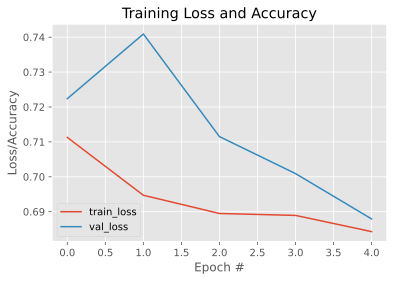

In [77]:
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History.history["loss"], label="train_loss")
plt.plot(N, History.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [78]:
%tensorboard --logdir logs --port=6061

Reusing TensorBoard on port 6061 (pid 21200), started 2:58:52 ago. (Use '!kill 21200' to kill it.)

We can try to visualize the reconstructed inputs and the encoded representations.

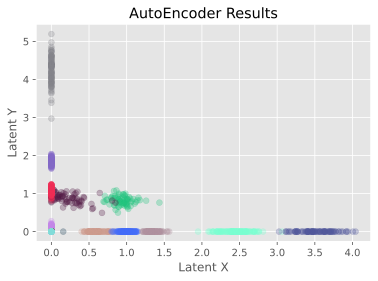

In [68]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    latent_space = encoded_imgs[y_test==label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=colors[index])
    
plt.xlabel("Latent X")
plt.ylabel("Latent Y")
plt.title('AutoEncoder Results')
plt.show()

In [59]:
silhouette_score(encoded_imgs, y_test)

-0.04017883

## AutoEncoders for MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import pandas as pd
import seaborn as sns
import random

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
(mnist_train, a), (mnist_test, b) = mnist.load_data()

In [ ]:
mnist_train.shape

In [ ]:
mnist_train.shape[1:]

In [ ]:
# We will normalize all values between 0 and 1
mnist_train = mnist_train.astype('float32') / 255.
mnist_test = mnist_test.astype('float32') / 255.

# we will flatten the 28x28 images into vectors of size 784.
mnist_train = mnist_train.reshape((len(mnist_train), np.prod(mnist_train.shape[1:]))) # --> (60000, (28*28))
mnist_test  = mnist_test.reshape((len(mnist_test), np.prod(mnist_test.shape[1:]))) # --> (10000, (28*28))

print(mnist_train.shape)
print(mnist_test.shape)

In [ ]:
epochs = 50
batch_size=32

History_mnist = autoencoder.fit(x = mnist_train,
                                y = mnist_train,
                                epochs = epochs,
                                batch_size = batch_size,
                                shuffle = True,
                                validation_data = (X_test, X_test))

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images    
    ax = plt.subplot(3, n, 2*20+i + 1 )
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Image Denoising using AutoEncoders

In [3]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

fm_X_train shape (60000, 28, 28)
fm_X_test shape (10000, 28, 28)


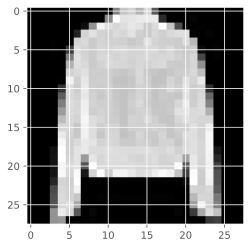

In [4]:
print('fm_X_train shape', fm_X_train.shape)
print('fm_X_test shape', fm_X_test.shape)
plt.imshow(fm_X_train[625], cmap='gray')
plt.show()

### Perform Data visualization

6


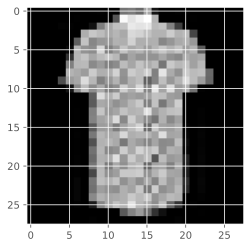

In [5]:
i = random.randint(0,60000)
print(fm_y_train[i])
plt.imshow(fm_X_train[i], cmap='gray')
plt.show()

- 0 = T-shirt/top
- 1 = Trouser
- 2 = Pullover
- 3 = Dress
- 4 = Coat
- 5 = Sandal
- 6 = Shirt
- 7 = Sneaker
- 8 = Bag
- 9 = Ankle boot

In [ ]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_training = len(fm_X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid*L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(fm_X_train[index])
    axes[i].set_title(fm_y_train[index], fontsize = 8, color = 'w')
    axes[i].axis('off')
plt.show()

In [6]:
# Normalize data
fm_X_train = fm_X_train/255.0
fm_X_test = fm_X_test/255.0

In [7]:
# Add noise to images
noise_factor = 0.38

noise_train_dataset = list()
noise_test_dataset = list()

for img in fm_X_train:
    noisy_image = img + noise_factor*np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    noise_train_dataset.append(noisy_image)

for img in fm_X_test:
    noisy_image = img + noise_factor*np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    noise_test_dataset.append(noisy_image)

In [8]:
noise_train_dataset = np.array(noise_train_dataset)
noise_test_dataset = np.array(noise_test_dataset)

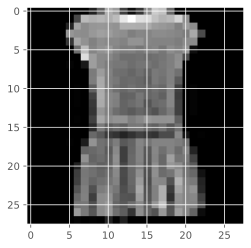

In [9]:
plt.imshow(fm_X_train[3], cmap='gray')
plt.show()

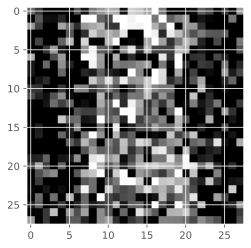

In [10]:
plt.imshow(noise_train_dataset[3], cmap='gray')
plt.show()

### UNDERSTAND THE THEORY AND INTUITION BEHIND AUTOENCODERS

![image.png](attachment:image.png)

Introduction to autoencoders by Jeremy Jordan

https://www.jeremyjordan.me/autoencoders/

![image.png](attachment:image.png)

![image.png](attachment:image.png)

### Convolutional autoencoder

In [11]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters =  8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters =  8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name = 'LatentSpace')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [12]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
LatentSpace (MaxPooling2D)   (None, 4, 4, 8)           0     

In [13]:
fm_X_train = np.reshape(fm_X_train, (len(fm_X_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
noise_train_dataset = np.reshape(noise_train_dataset, (len(noise_train_dataset), 28, 28, 1))

fm_X_test = np.reshape(fm_X_test, (len(fm_X_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
noise_test_dataset = np.reshape(noise_test_dataset, (len(noise_test_dataset), 28, 28, 1))

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
import os
from tensorflow.keras.callbacks import TensorBoard

# %reload_ext tensorboard

In [15]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [32]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%m%d_%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

epochs = 8
batch_size = 32

HistoryAE = autoencoder.fit(noise_train_dataset,
                            fm_X_train,
                            epochs = epochs,
                            batch_size = batch_size,
                            validation_data = (noise_test_dataset, fm_X_test),
                            callbacks=[eStop, tensorboard_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 8s 127us/sample - loss: 0.2915 - val_loss: 0.2936- loss: - ETA - ETA: - ETA:  - ETA:  - ETA: 1s - loss:  - ETA:
Epoch 2/8
60000/60000 [==============================] - 8s 125us/sample - loss: 0.2914 - val_loss: 0.2937
Epoch 3/8
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2914 - val_loss: 0.2937TA: 0s - lo
Epoch 4/8
60000/60000 [==============================] - 8s 126us/sample - loss: 0.2914 - val_loss: 0.2933
Epoch 5/8
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2913 - val_loss: 0.2933A: 0s - loss:
Epoch 6/8
60000/60000 [==============================] - 8s 126us/sample - loss: 0.2913 - val_loss: 0.2931
Epoch 7/8
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2913 - val_loss: 0.2935
Epoch 8/8
60000/60000 [==============================] - 8s 127us/sample - loss: 0.2912 - val_loss: 0.2933


In [33]:
%tensorboard --logdir logs --port=6061

Reusing TensorBoard on port 6061 (pid 21200), started 0:27:21 ago. (Use '!kill 21200' to kill it.)

In [28]:
from tensorboard import notebook

# notebook.list() # View open TensorBoard instances logs wandb

%tensorboard --logdir logs --port=6061
notebook.display(port=6061, height=1000)

Reusing TensorBoard on port 6061 (pid 21200), started 0:17:40 ago. (Use '!kill 21200' to kill it.)

Selecting TensorBoard with logdir logs (started 0:17:41 ago; port 6061, pid 21200).


In [ ]:
plt.plot(HistoryAE.history['loss'], label="loss")
plt.plot(HistoryAE.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [ ]:
Evaluation = autoencoder.evaluate(noise_test_dataset,
                                  fm_X_test,
                                  batch_size=batch_size,
                                  verbose=2)

print('Test Loss: {:.3f}'.format(Evaluation))

In [ ]:
predicted = autoencoder.predict(noise_test_dataset[:10])

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_dataset[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>

# Introduction to Anomaly Detection in Time Series with Keras

## Task 1: Project Overview and Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 7
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

## Task 2: Load and Inspect the S&P 500 Index Data

In [ ]:
df = pd.read_csv('datasets/S&P_500_Index_1927_2020.csv', parse_dates=['Date'])
print(df.shape)
display(df)

In [ ]:
mask = (df['Date'] > '2000-01-01') & (df['Date'] <= '2019-12-31')
df = df.loc[mask]
df = df.filter(items=['Date', 'Close'], axis=1)
df.reset_index(drop=True, inplace=True)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= df.Date, y= df.Close, mode='lines', name='Close'))
fig.update_layout(showlegend = True)
fig.show()

## Task 3: Data Preprocessing

In [ ]:
train_size = int(len(df)* 0.8)
test_size =  len(df) - train_size

train = df.iloc[0:train_size]
test  = df.iloc[train_size:len(df)]

print(train.shape, test.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

## Task 4: Create Training and Test Splits

In [ ]:
def create_sequences(X, y, time_steps=1):

  Xs, ys = [], []

  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:(i+time_steps)].values) # Extrae los n_timesteps valores, 
    ys.append(y.iloc[i+time_steps]) # Extrae los n_timesteps+1 valores

  return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 20

X_train, y_train = create_sequences(train[['Close']], train.Close, time_steps) # Atencion al doble parentesis del Train[['Close']]
X_test, y_test = create_sequences(test[['Close']], test.Close, time_steps)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

## Task 5: Build an LSTM Autoencoder

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, AlphaDropout

In [ ]:
timesteps = X_train.shape[1] # 20
num_features = X_train.shape[2] # 1

In [ ]:
model = Sequential(name='LSTM_AutoEncoder', layers=[
        
        LSTM(150, input_shape=(timesteps, num_features), recurrent_dropout=0.125),
        Dropout(0.2),
    
        RepeatVector(timesteps),
        LSTM(150, return_sequences=True, recurrent_dropout=0.125),
        Dropout(0.2),

        TimeDistributed(Dense(num_features, activation='selu'))                 
])

model.compile(optimizer='Adam', loss='mae')

model.summary()

## Task 6: Train the Autoencoder

In [ ]:
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[eStop],
                    shuffle = False)

## Task 7: Plot Metrics and Evaluate the Model

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
X_train_predicted = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_predicted - X_train), axis=1), columns=['Error'])

In [ ]:
model.evaluate(X_test, y_test, verbose=2, batch_size=32)

In [ ]:
sns.distplot(train_mae_loss, bins=100, kde=True)
plt.show()

In [ ]:
Threshold = 0.525

In [ ]:
X_test_predicted = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_predicted - X_test), axis=1)

In [ ]:
sns.distplot(test_mae_loss, bins=100, kde=True)
plt.show()

## Task 8: Detect Anomalies in the S&P500 Index data

In [ ]:
test_score_df = pd.DataFrame(test[time_steps:].Date)
test_score_df['Close'] = test[time_steps:].Close
test_score_df['loss'] = test_mae_loss
test_score_df['Threshold'] = Threshold
test_score_df['Anomaly'] = test_score_df.loss > test_score_df.Threshold
test_score_df.tail()

In [ ]:
test_score_df['Anomaly'][test_score_df['Anomaly']==True].count()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= test[time_steps:].Date, y= test_score_df.loss, mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x= test[time_steps:].Date, y= test_score_df.Threshold, mode='lines', name='Threshold'))
fig.update_layout(showlegend = True)
fig.show()

In [ ]:
anomalies = test_score_df[test_score_df.Anomaly == True]
anomalies.head()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= test[time_steps:].Date, y=scaler.inverse_transform(test[time_steps:].Close), mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x= anomalies.Date, y=scaler.inverse_transform(anomalies.Close), mode='markers', name='Anomaly'))
fig.update_layout(showlegend = True)
fig.show()

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [7]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir TFlogs (started 0:11:16 ago; pid 1320)
  - port 6006: logdir TF_logs (started 0:03:28 ago; pid 13428)
  - port 6006: logdir ./logs (started 0:14:36 ago; pid 16016)
  - port 6006: logdir logsTF (started 1:03:17 ago; pid 22224)
  - port 6006: logdir logsFT (started 3:26:09 ago; pid 22244)
  - port 6006: logdir logsTF20200721-210003 (started 3:23:50 ago; pid 25956)
  - port 6006: logdir logs (started 1:10:44 ago; pid 29992)
  - port 6006: logdir logs/fit (started 3:29:51 ago; pid 30144)
  - port 6006: logdir logsFT (started 3:37:23 ago; pid 31008)
  - port 6006: logdir logs (started 2:57:48 ago; pid 33456)


In [2]:
import tensorflow as tf
import datetime, os

In [12]:
# https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=KBHp6M_zgjp4
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

def train_model():
  
  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            epochs=10,
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.4993 - accuracy: 0.8212 - val_loss: 0.4055 - val_accuracy: 0.8542
Epoch 2/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3818 - accuracy: 0.8600 - val_loss: 0.3781 - val_accuracy: 0.8614
Epoch 3/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3494 - accuracy: 0.8718 - val_loss: 0.3702 - val_accuracy: 0.8645
Epoch 4/10
19008/60000 [========>.....................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8772

KeyboardInterrupt: 

In [11]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 33456), started 3:01:09 ago. (Use '!kill 33456' to kill it.)

In [22]:
%tensorboard --logdir logs
notebook.display(port=6006, height=1000)

Reusing TensorBoard on port 6006 (pid 33456), started 18:50:49 ago. (Use '!kill 33456' to kill it.)

Selecting TensorBoard with logdir TF_logs (started 15:56:29 ago; port 6006, pid 13428).


In [23]:
!kill 33456

'kill' is not recognized as an internal or external command,
operable program or batch file.
